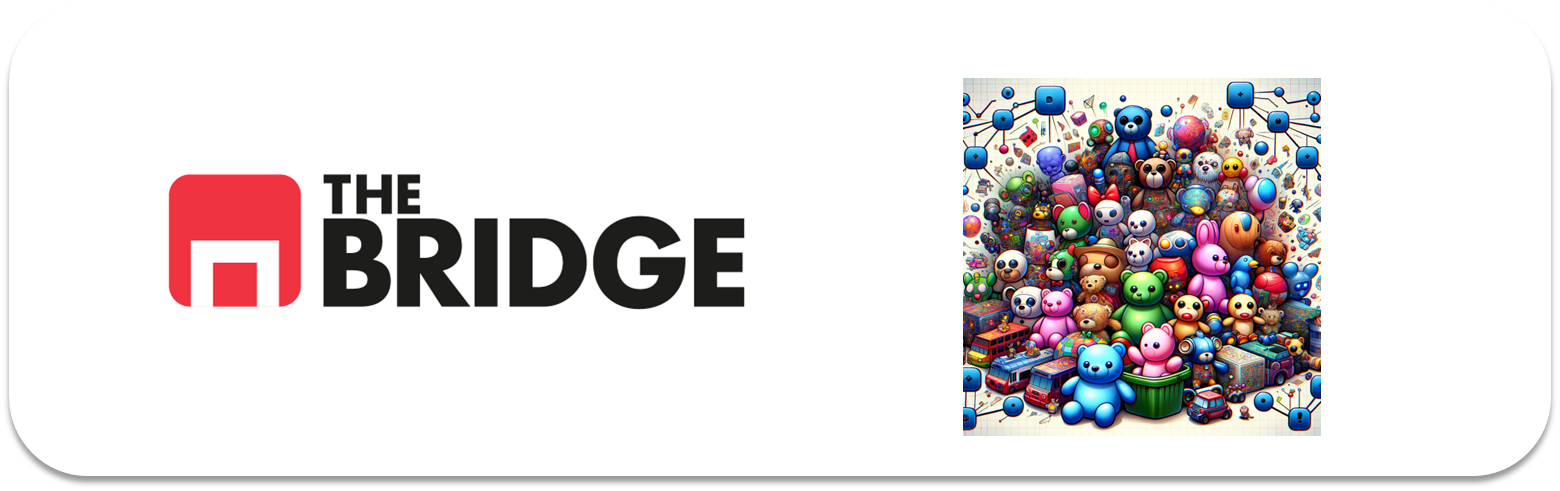

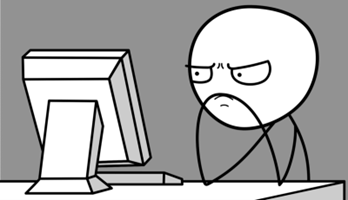

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [170]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN, AgglomerativeClustering

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


_________________________________________
#### **1.** Entender el problema

Negocio necesita encontrar un segmentador de posibles bebidas, por lo que las mezclas de esa segmentación de lugar a las bebidas energéticas.

Los quíicos no quieren que haya menos de 3 segmento (clusters) ni más de 5 por lo que tenemos un rango de $k$ entre 3 y 5.

#### **2.** Cargar datos y visualizar

In [171]:
drinks_data = pd.read_csv('./data/empowering_drinks.csv', sep= '|')

In [172]:
drinks_data.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [173]:
drinks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [174]:
drinks_data.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


Con estas visualizaciones podemos concluir que no hay presencia de nulos a priori, ni de outliers y la distribución de las 5 variables son muy similares, sin puntos destacables

#### **3.** MiniEda: Selección de Features

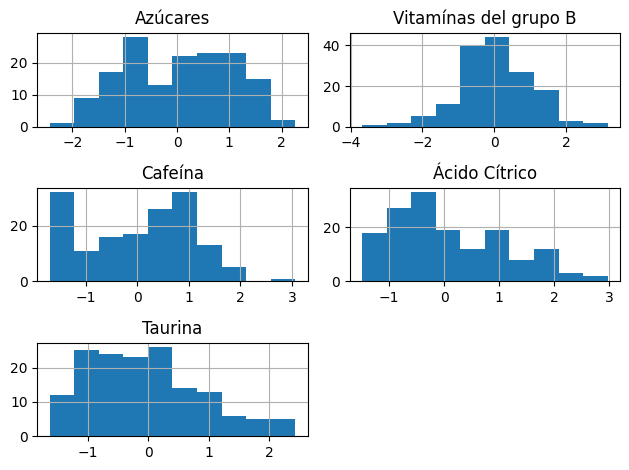

In [175]:
# Empiezo a ver las distribuciones y las escalas
drinks_data.hist()
plt.tight_layout()

Aquí confirmamos lo observado en el apartado anteriors, están casi estabilizadas teniendo una varianza similar y además tienen una escala pequeña entre -3,3 en general.

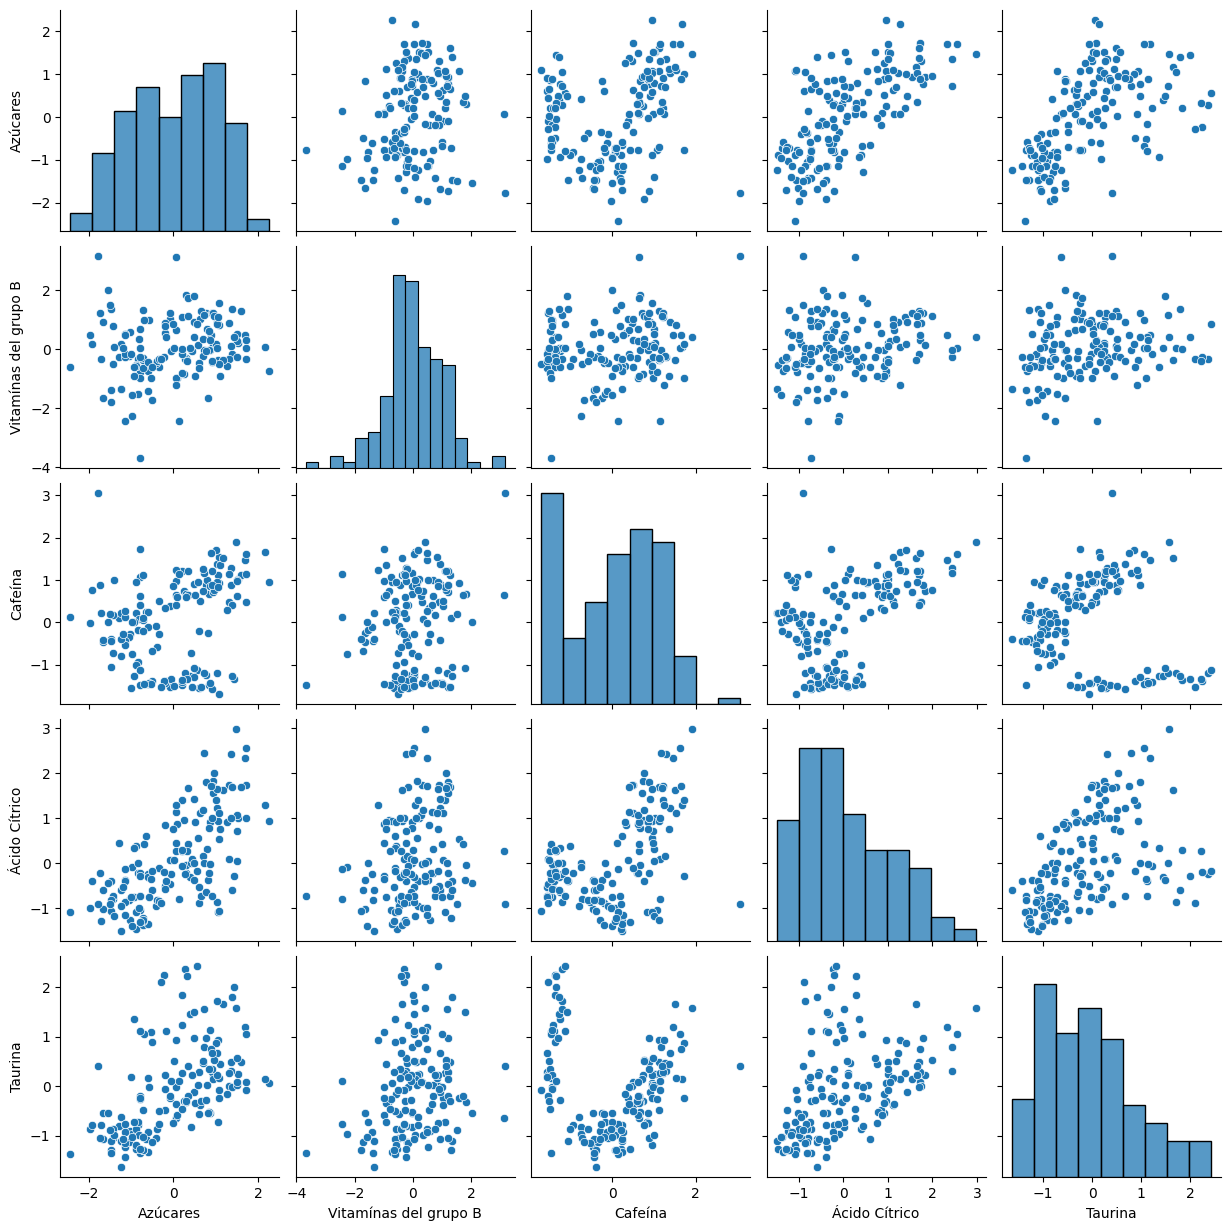

In [176]:
# Visualizo un pairplot
sns.pairplot(drinks_data)

Es un poco distinguir varios clusters en estos gráficos de dispersión. En cambio, podemos ver una diferencia de concentración de datos entre `Cafeína`y `Taurina` en posibles 3 o 4 clusters.

Lo voy a visualizar con colores para ver si está clara la división.

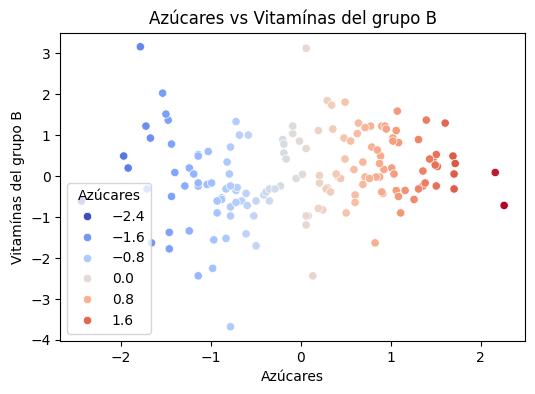

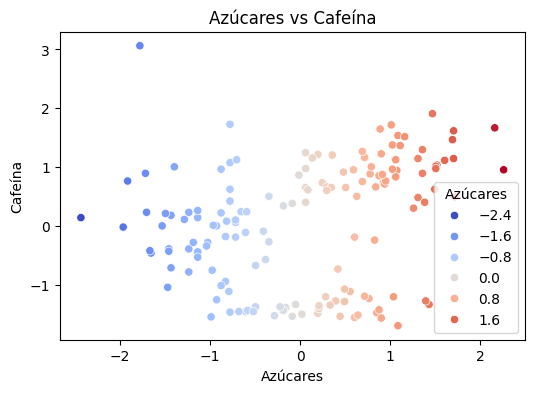

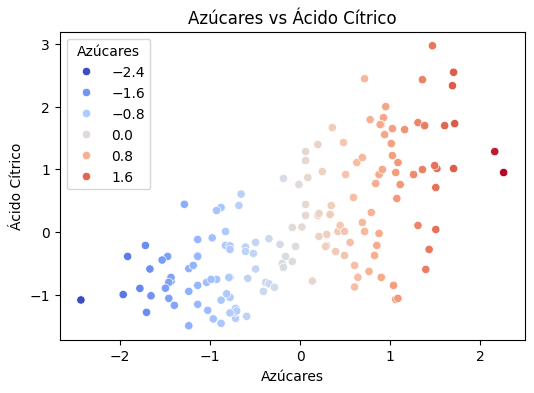

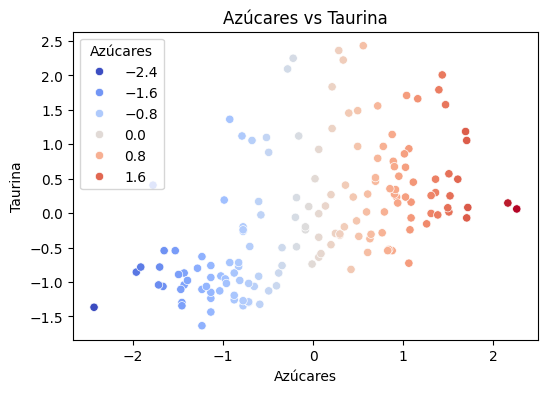

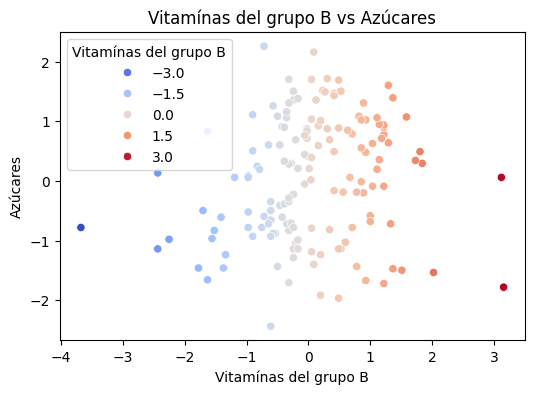

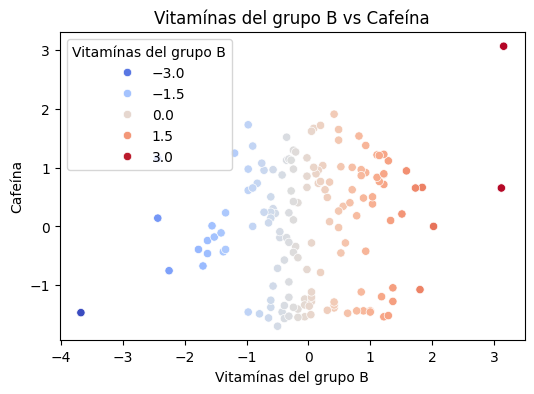

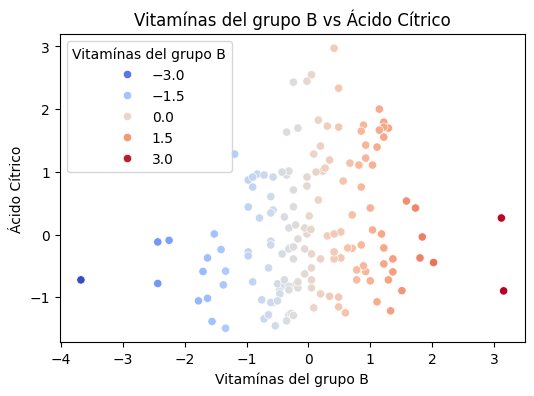

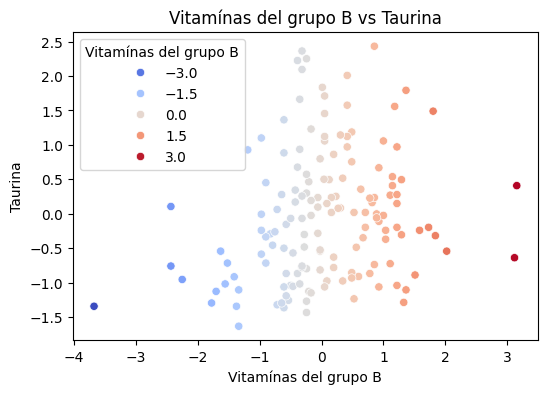

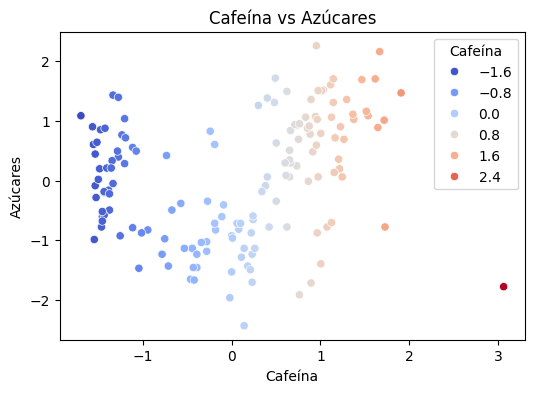

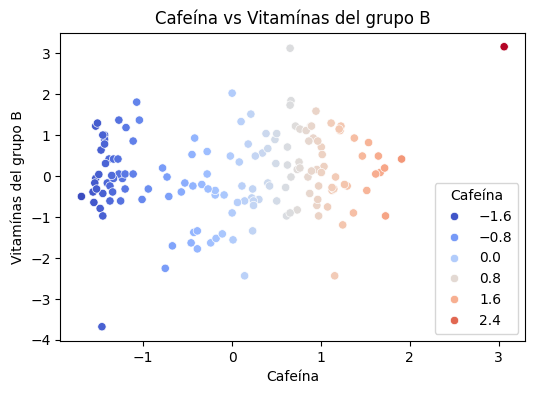

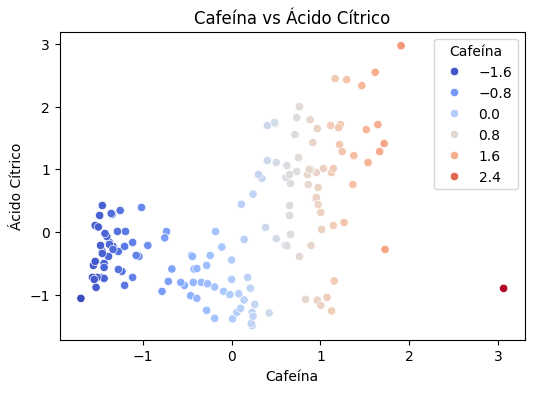

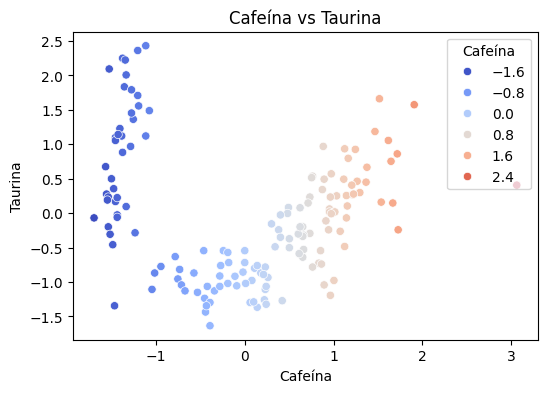

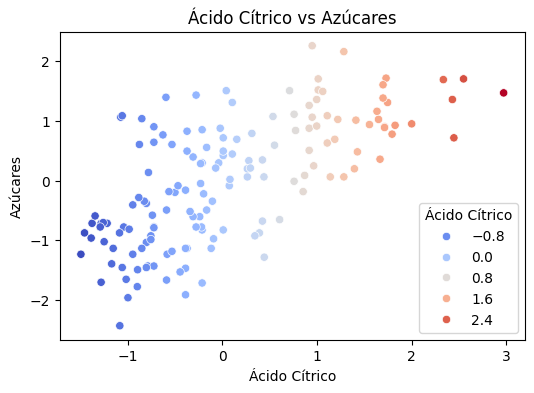

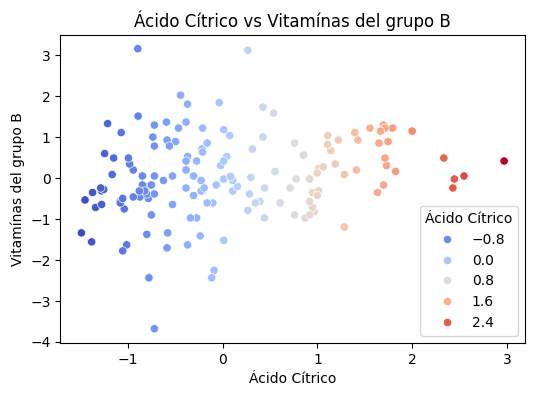

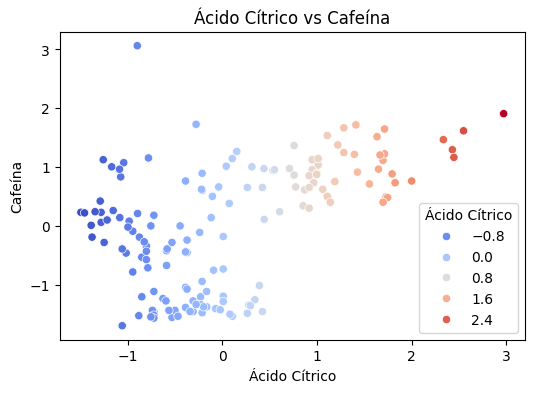

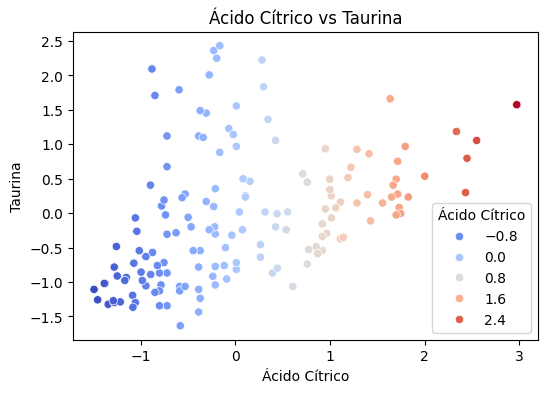

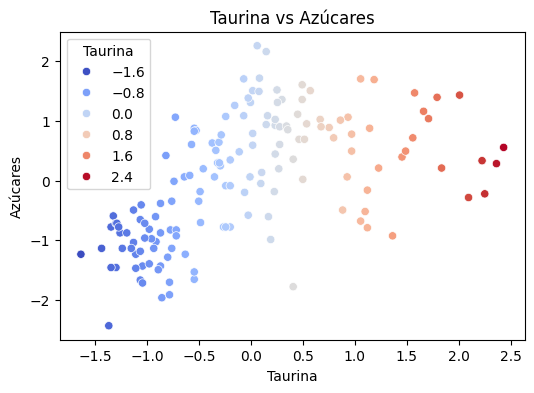

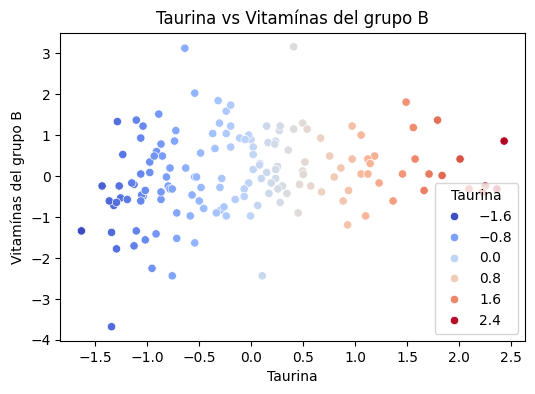

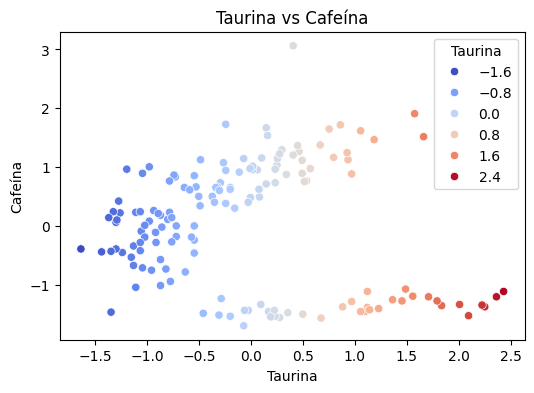

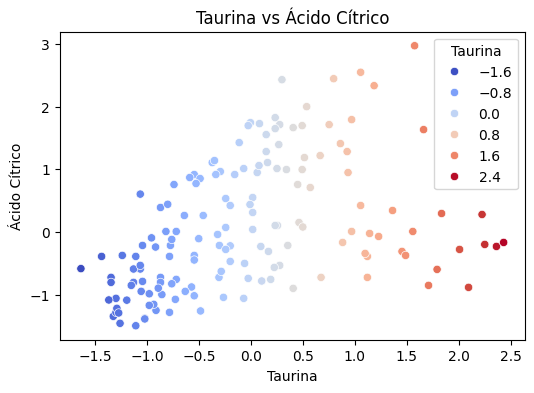

In [177]:
for i, col1 in enumerate(drinks_data.columns):
    for j, col2 in enumerate(drinks_data.columns):
        if col1 != col2:  # Evitar comparar una variable consigo misma
            plt.figure(figsize=(6, 4))
            sns.scatterplot(data=drinks_data, x=col1, y=col2, hue=col1, palette="coolwarm")
            plt.title(f'{col1} vs {col2}')
            plt.show()

Comparando `Azúcares` con el resto:

- Tienen una correlación positiva con todas pero se ve una pequeña segmentación con `Ácido Cítrico` en 3 segmentos.

Comparando `Vitaminas del grupo B`:

- No veo segmentación clara

Comparando `Cafeína`:

- Con `Taurina` veo muy clara la segmentación en 3.
- Posibilidad con `Ácido Cítrico`.

Comparando `Ácido Cítrico`:

- Las que he nombrado antes: `Azúcares` y `Cafeína`.

Comparando `Taurina`:

- Con `Cafeína`


In [178]:
# Selecciono las todas las variables como Features menos 'Vitaminas del grupo B'
features = [col for col in drinks_data.columns if col != 'Vitamínas del grupo B']
features

['Azúcares', 'Cafeína', 'Ácido Cítrico', 'Taurina']

In [179]:
drinks_data_features = drinks_data[features]

#### **4.** Tratamiento de Features

Como tienen una distribución muy similar, no voy a hacer ningún tipo de tratamiento en las **Features**

#### **5.** Selección de modelos y de hiperparámetros

Voy a usar **DBSCAN** ya que me lo pide el enunciado y el otro va ser **Clusering Jerárquico** ya que quiere ver la mejor relación entre distancias de los puntos.

#### **6.** Entrenamiendo y visualización de los resultados

##### **DBSCAN**

In [180]:
# Primero entreno y veo las anomalias
anomalias_percent = []

for eps in np.linspace(0.001,1,50): # Primero lo hice entre 0.001 y 3 y no me salia ningun valor por lo que lo baje.
    dbscan = DBSCAN(eps=eps, min_samples=2*drinks_data_features.shape[1])
    dbscan.fit(drinks_data_features)

    perc_anomalias  = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    anomalias_percent.append(perc_anomalias)

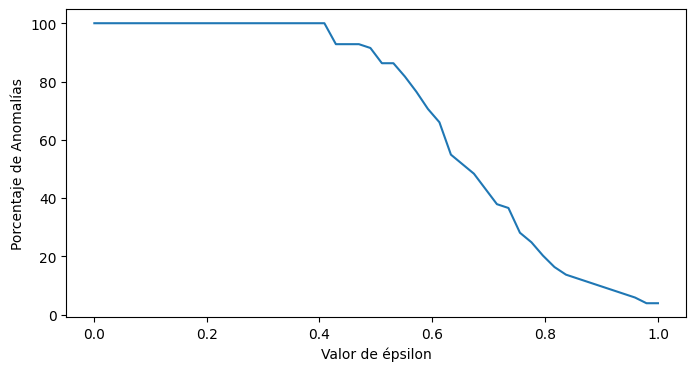

In [181]:
# Visualizo el procentaje de anomalias con el valor de eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,1,50),y=anomalias_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

In [182]:
# Aplico una estimacion tipo "codo", para valores por debajo del 10%
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,1,50)) if 0.8 <= val <= 1]:
    print(f"Para {eps}: {anomalias_percent[indice]}% de anomalías")

Para 0.8165102040816327: 16.33986928104575% de anomalías
Para 0.8368979591836735: 13.72549019607843% de anomalías
Para 0.8572857142857143: 12.418300653594772% de anomalías
Para 0.8776734693877551: 11.11111111111111% de anomalías
Para 0.898061224489796: 9.803921568627452% de anomalías
Para 0.9184489795918368: 8.49673202614379% de anomalías
Para 0.9388367346938776: 7.189542483660131% de anomalías
Para 0.9592244897959185: 5.882352941176471% de anomalías
Para 0.9796122448979593: 3.9215686274509802% de anomalías
Para 1.0: 3.9215686274509802% de anomalías


A partir de 0.83 la pendiente de decrecimiento se va relantizando bastante por lo que nos quedaremos con ese valor de `eps`

In [183]:
#Entreno para eps=0.83
dbscan_2 = DBSCAN(eps=0.83, min_samples=2*drinks_data_features.shape[1])
dbscan_2.fit(drinks_data_features)

DBSCAN(eps=0.83, min_samples=8)

Quería visualizarlo y como tenia 4 features no lo podía visualizar en una gráfica por lo que estuve investigando y reduje en 2D la gráfica para poder verlo con PCA

In [184]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # Redujo en 2D
reduced_data = pca.fit_transform(drinks_data_features)
drinks_data_features['Labels'] = dbscan_2.labels_

# Convertir a DataFrame para visualización
reduced_dbscan = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_dbscan['Cluster'] = drinks_data_features['Labels'] 

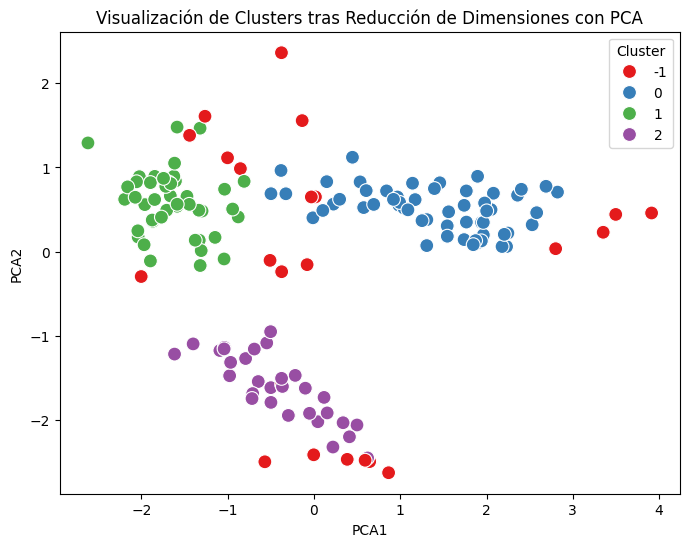

In [185]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=reduced_dbscan, palette='Set1', s=100)
plt.title('Visualización de Clusters tras Reducción de Dimensiones con PCA')
plt.show()

Veo que ha encontrado 3 etiquetas, el mínimo que nos pide negocio por lo que es una buena señal y también se visualizan las anomalías.

##### **Clustering Jerárquico**

In [186]:
drinks_data_jerar = drinks_data[features]

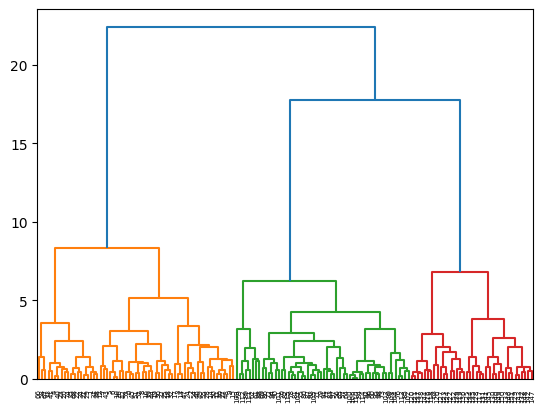

In [187]:
# Visualizamos el dendrograma
selected_data = drinks_data_jerar
clusters = shc.linkage(selected_data, 
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Vemos claramente la separacion de los 3 clusters principales

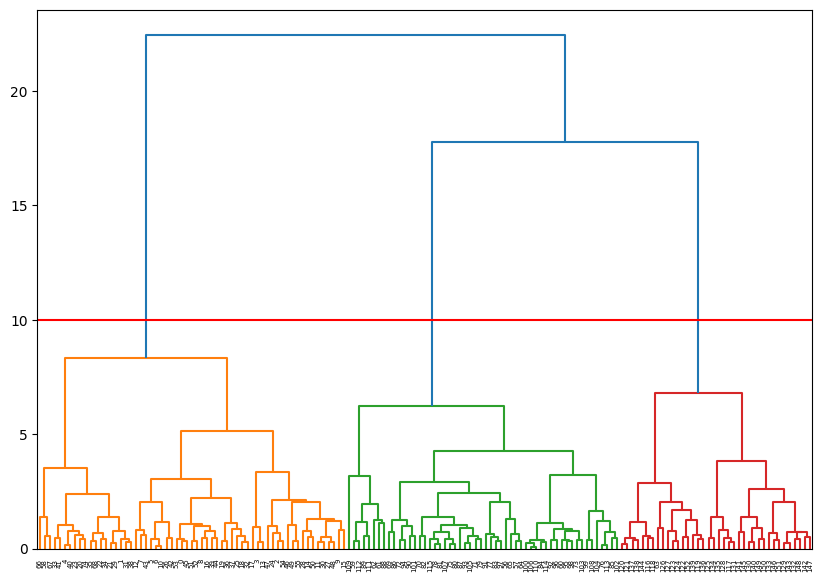

In [188]:
# Lo visualizamos mejor a partir de la linea roja
plt.figure(figsize=(10, 7))
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 10, color = 'r', linestyle = '-')

Por lo que defenitivamente seleccionaremos 3 clusters

In [189]:
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(drinks_data_jerar)
clustering_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

Vemos que ha clasificado en 3 clusters. Ahora lo visualizamos con la misma técnica que usamos en DBSCAN

In [190]:
pca = PCA(n_components=2) # Redujo en 2D
reduced_data = pca.fit_transform(drinks_data_jerar)
drinks_data_jerar['Clusters'] = clustering_model.labels_

# Convertir a DataFrame para visualización
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = drinks_data_jerar['Clusters'] 

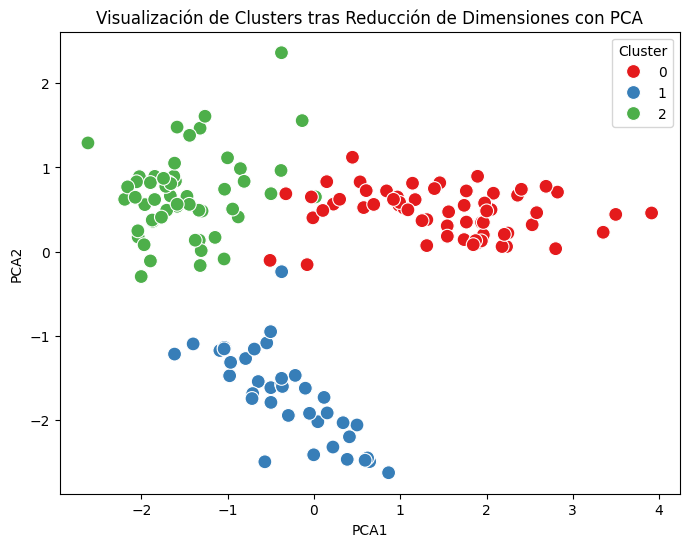

In [191]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=reduced_df, palette='Set1', s=100)
plt.title('Visualización de Clusters tras Reducción de Dimensiones con PCA')
plt.show()

Por lo que se puede observar, vemos una buena distribución de los clusters en la gráfica.

#### **7.** Comparación entre ambos modelos

Si vemos las dos visualizaciones de cómo han clasificado cada cluster, podemos observar que el que mejor agrupa es **Clustering Jerárquico** y que no puede detectar anomalías y, en este caso, a mi parecer, lo veo más adecuado
____________________________________

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [192]:
new_experiments = pd.read_csv('./data/new_experiments.csv', sep='|')
new_experiments

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [193]:
new_experiments_features = new_experiments[features]

In [194]:
# Elijo clustering jerarquico
clustering_model_new = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model_new.fit(new_experiments_features)

AgglomerativeClustering(n_clusters=3)

In [195]:
# Lo visualizamos
pca = PCA(n_components=2) # Redujo en 2D
reduced_data = pca.fit_transform(new_experiments_features)
new_experiments_features['Clusters'] = clustering_model_new.labels_

# Convertir a DataFrame para visualización
reduced_df = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
reduced_df['Cluster'] = new_experiments_features['Clusters'] 

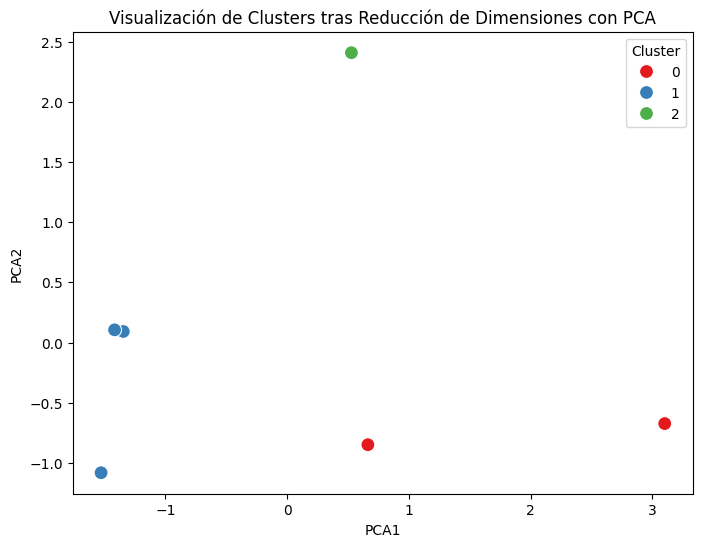

In [196]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=reduced_df, palette='Set1', s=100)
plt.title('Visualización de Clusters tras Reducción de Dimensiones con PCA')
plt.show()

Hay muy pocos valores pero sigue clasificando bien, creo

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.